# Reinforcement Learning assignment: Worm
### Made by Group 23:
- Kaj de Lange, s1147197
- Troy Dijsselbloem, s1145721
- Julian Dinnissen, s1135596
- Sten Nellen, s1151303

In [1]:
import importlib
import numpy as np
import gymnasium as gym

import dp, mc, td
importlib.reload(dp)
importlib.reload(mc)
importlib.reload(td)
from dp import *
from mc import *
from td import *

# Abstract

_insert your abstract here_

# 0. Environment

In [2]:
from environment import MouseEnv
from gymnasium.envs.registration import register

    
register(id="mouse-v0", entry_point="__main__:MouseEnv")


#Create the environment
env = gym.make("mouse-v0")
# Interact with the environment
obs, info = env.reset()
for _ in range(10):
    action = env.action_space.sample() # Random action
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done:
        print("Game Over!")
        break
env.close()

      ╭───╮
╭─────╯ h │
│ 0 0 c 0 │
│ 0 0 0 0 │
│ m 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 0 c 0 │
│ m 0 0 0 │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 0 c 0 │
│ m 0 0 0 │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ m 0 c 0 │
│ 0 0 0 0 │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 0 c 0 │
│ m 0 0 0 │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ m 0 c 0 │
│ 0 0 0 0 │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ m 0 c 0 │
│ 0 0 0 0 │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ m 0 c 0 │
│ 0 0 0 0 │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 0 c 0 │
│ m 0 0 0 │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 0 c 0 │
│ m 0 0 0 │
│ 0 0 0 0 │
╰─────────╯


# 1. Introduction

_insert your introduction in this cell_

_describe your environment and the problem the agent has to solve_

_describe the objective of the report (e.g. comparing various RL algorithms) and how you are going to accomplish this (research question)_

_don't forget to add plots/images of the environment, can be done via code cells, but also by inserting .png files into the jupyter notebook_

# 2. Dynamic Programming algorithms

First run the Dynamic Programming algorithms (Policy Iteration and Value Iteration) by calling functions from the separate `dp.py` file, and create plots. Then, fill in the cell completing your 'report' within this file.

In [3]:
# Import plotting library
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

In [4]:
# Plotting helper functions

def _style_axis(ax, title: str, xlabel: str, ylabel: str, grid_axis: str = "both"):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if grid_axis == "both":
        ax.grid(True)
    else:
        ax.grid(axis=grid_axis, alpha=0.3)

def _get_ax(ax, figsize=(6, 4)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        return fig, ax, True
    return ax.figure, ax, False

# Algorithm detail plotting helper functions

def _plot_delta(ax, history: list[float], title: str):
    ax.plot(range(len(history)), history)
    _style_axis(ax, title, "Iteration", r"$\Delta$")

def _plot_value_history(ax, value_history: dict[int, list[float]], title: str):
    for history in value_history.values():
        ax.plot(range(len(history)), history, alpha=0.75, linewidth=1)
    unique_trajectories = len({tuple(np.round(history, 10)) for history in value_history.values()})
    total_tracked = len(value_history)
    _style_axis(ax, title, "Iteration", "Value")
    ax.text(0.02, 0.98, f"states: {total_tracked}, unique trajectories: {unique_trajectories}", transform=ax.transAxes, va="top")

def _plot_value_hist(ax, values: dict, title: str):
    ax.hist(list(values.values()), bins=100)
    _style_axis(ax, title, "Reward", "Frequency")

# Algorithm detail plotting function

def plot_algorithm_details(delta_history: list[float], value_history: dict[int, list[float]], values: dict, algorithm_name: str):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    _plot_delta(axes[0], delta_history, rf"{algorithm_name}: $\Delta$ per iteration")
    _plot_value_history(axes[1], value_history, f"{algorithm_name}: value history")
    _plot_value_hist(axes[2], values, f"{algorithm_name}: distribution of state rewards")
    plt.tight_layout()
    return fig, axes

In [5]:
# Policy plotting function

def plot_policy(policy: dict, values: dict | None = None, title: str = "Policy by cheese position"):
    "Plot policy as action arrows, with optional value-based square coloring"
    ARROWS = {0: "↑", 1: "→", 2: "↓", 3: "←"}
    rows, cols = MouseEnv.rows, MouseEnv.cols
    position_policy = policy_index_to_positions(policy, rows, cols)
    fig, axes = plt.subplots(rows, cols, figsize=(16, 10), constrained_layout=True)

    cmap = mcolors.LinearSegmentedColormap.from_list("value_map", ["red", "yellow", "green"])
    norm = mcolors.TwoSlopeNorm(vmin=MouseEnv.lose_punishment, vcenter=0, vmax=MouseEnv.win_reward)

    for c_row, c_col in np.ndindex(rows, cols):
        ax = axes[c_row, c_col]
        ax.set(xlim=(-0.5, cols - 0.5), ylim=(rows - 0.5, -0.5))
        ax.set_xticks([])
        ax.set_yticks([])

        # Terminal cheese locations are end states, so no action arrows are shown
        if c_col == 0 or c_row == rows - 1:
            ax.add_patch(plt.Rectangle((c_col - 0.5, c_row - 0.5), 1, 1, facecolor="lightpink")) # type: ignore
            ax.text(c_col, c_row, "C", ha="center", va="center", fontsize=20, fontweight="bold")
            continue

        # Draw colored backgrounds for each mouse position
        for m_row, m_col in np.ndindex(rows, cols):
            if (m_row, m_col) == (c_row, c_col):
                cell_color = "lightgray"
            elif values is None:
                cell_color = "white"
            else:
                state = MouseEnv.get_obs([m_row, m_col], [c_row, c_col], False)
                cell_color = cmap(norm(values[state]))
            ax.add_patch(plt.Rectangle((m_col - 0.5, m_row - 0.5), 1, 1, facecolor=cell_color)) # type: ignore

        # Draw cheese position marker
        ax.text(c_col, c_row, "C", ha="center", va="center", fontsize=20, fontweight="bold")

        # Draw action arrows for each mouse position
        for m_row, m_col in np.ndindex(rows, cols):
            if (m_row, m_col) == (c_row, c_col):
                continue
            action = position_policy[c_row, c_col, m_row, m_col]
            if not np.isnan(action):
                ax.text(m_col, m_row, ARROWS[int(action)], ha="center", va="center", fontsize=25)

    if values is not None:
        scalar_mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        scalar_mappable.set_array([])
        fig.colorbar(scalar_mappable, ax=axes.ravel().tolist(), shrink=0.7, pad=0.02, label="State value")

    fig.suptitle(title)
    return fig, axes

Policy Iteration iterations: 7


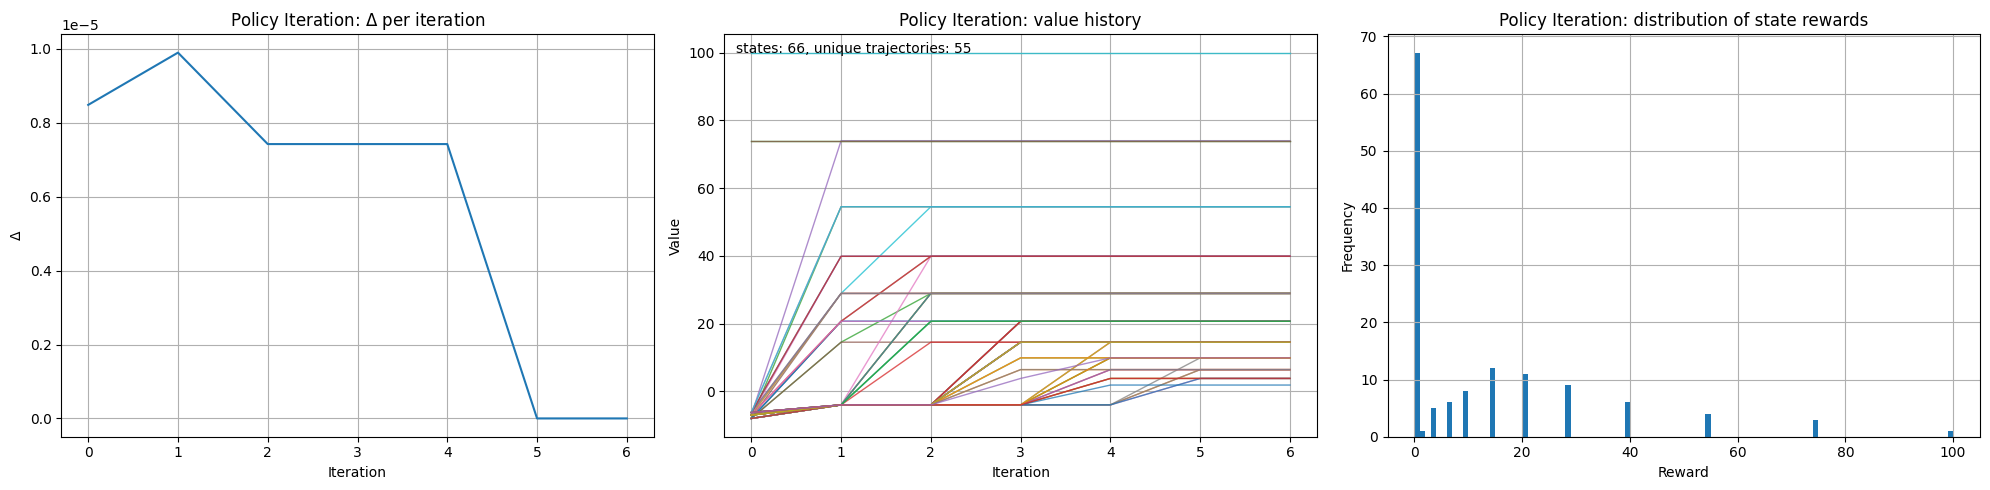

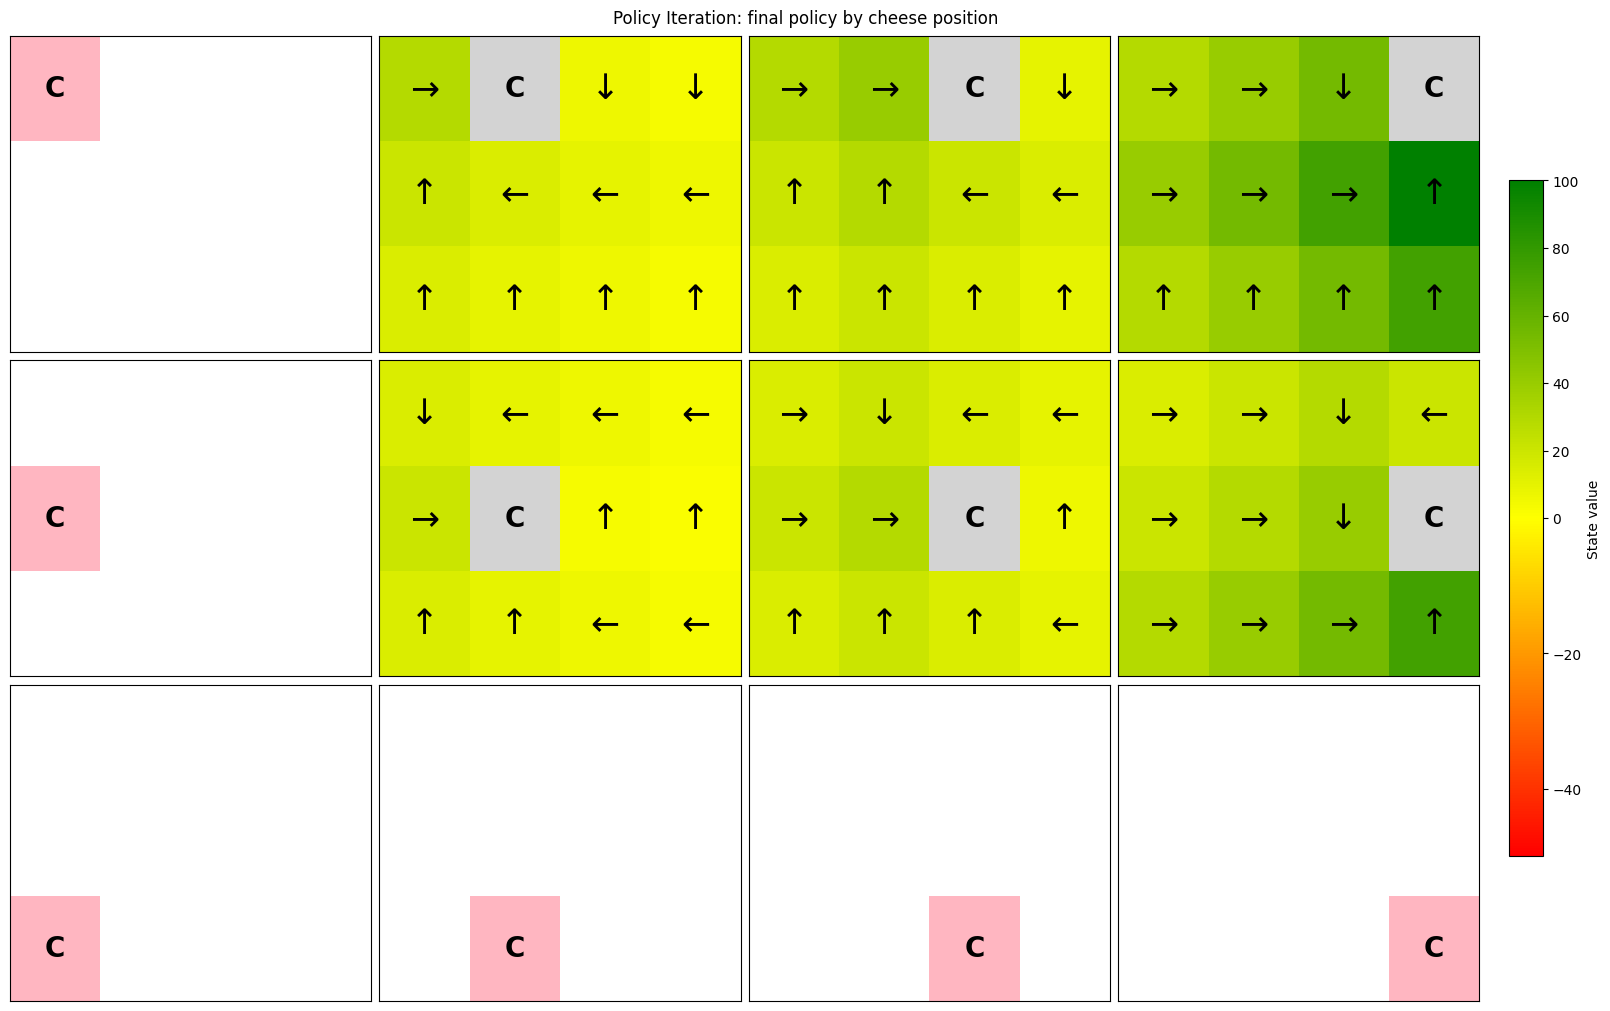

In [6]:
# Define algorithm parameters
theta = 1e-5
discount_rate = 0.75

# Call Policy Iteration algorithm
policy_itr_policy, policy_itr_values, delta_history, value_history = policy_iteration(theta=theta, gamma=discount_rate, track_history=True) # type: ignore

print(f"Policy Iteration iterations: {len(delta_history)}")

# Figure 1 (Policy Iteration details): delta convergence + value history + value distribution
plot_algorithm_details(delta_history, value_history, policy_itr_values, "Policy Iteration")
plt.show()

# Figure 2 (Policy Iteration policy)
plot_policy(policy_itr_policy, values=policy_itr_values, title="Policy Iteration: final policy by cheese position")
plt.show()

Value Iteration iterations: 7


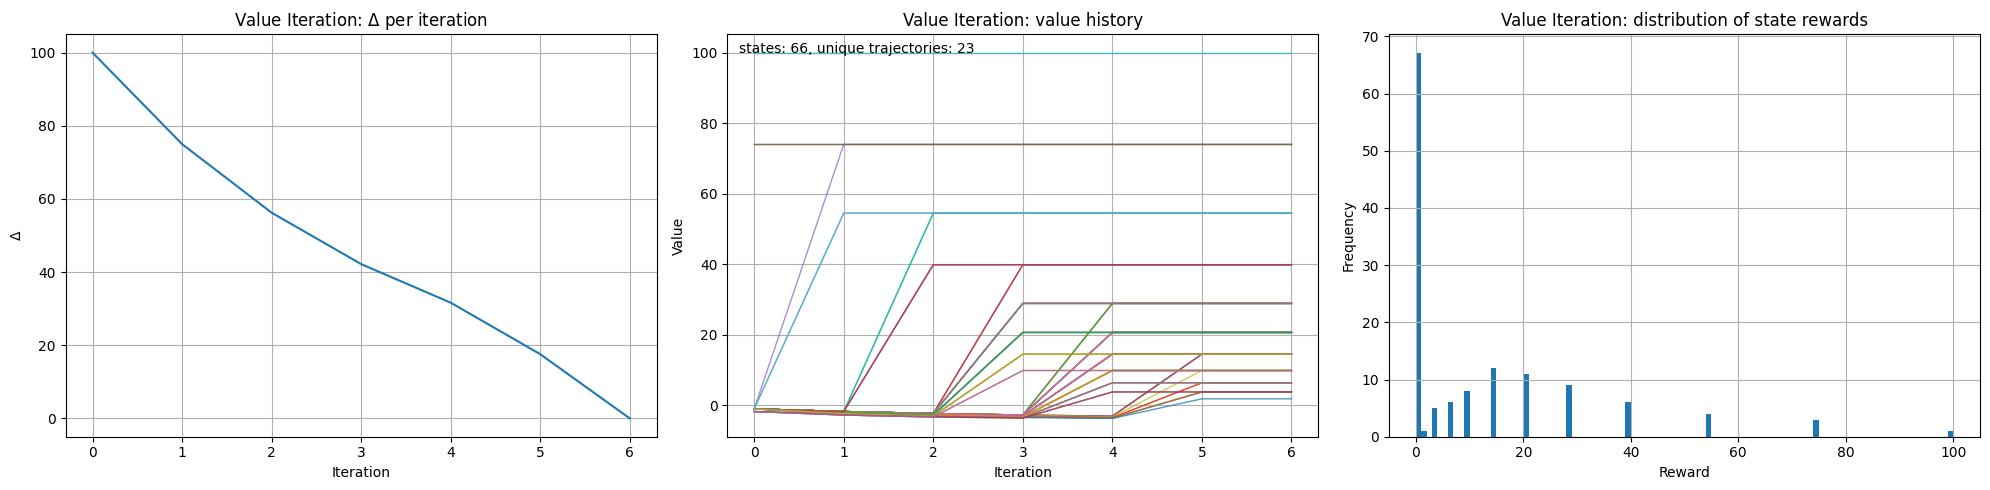

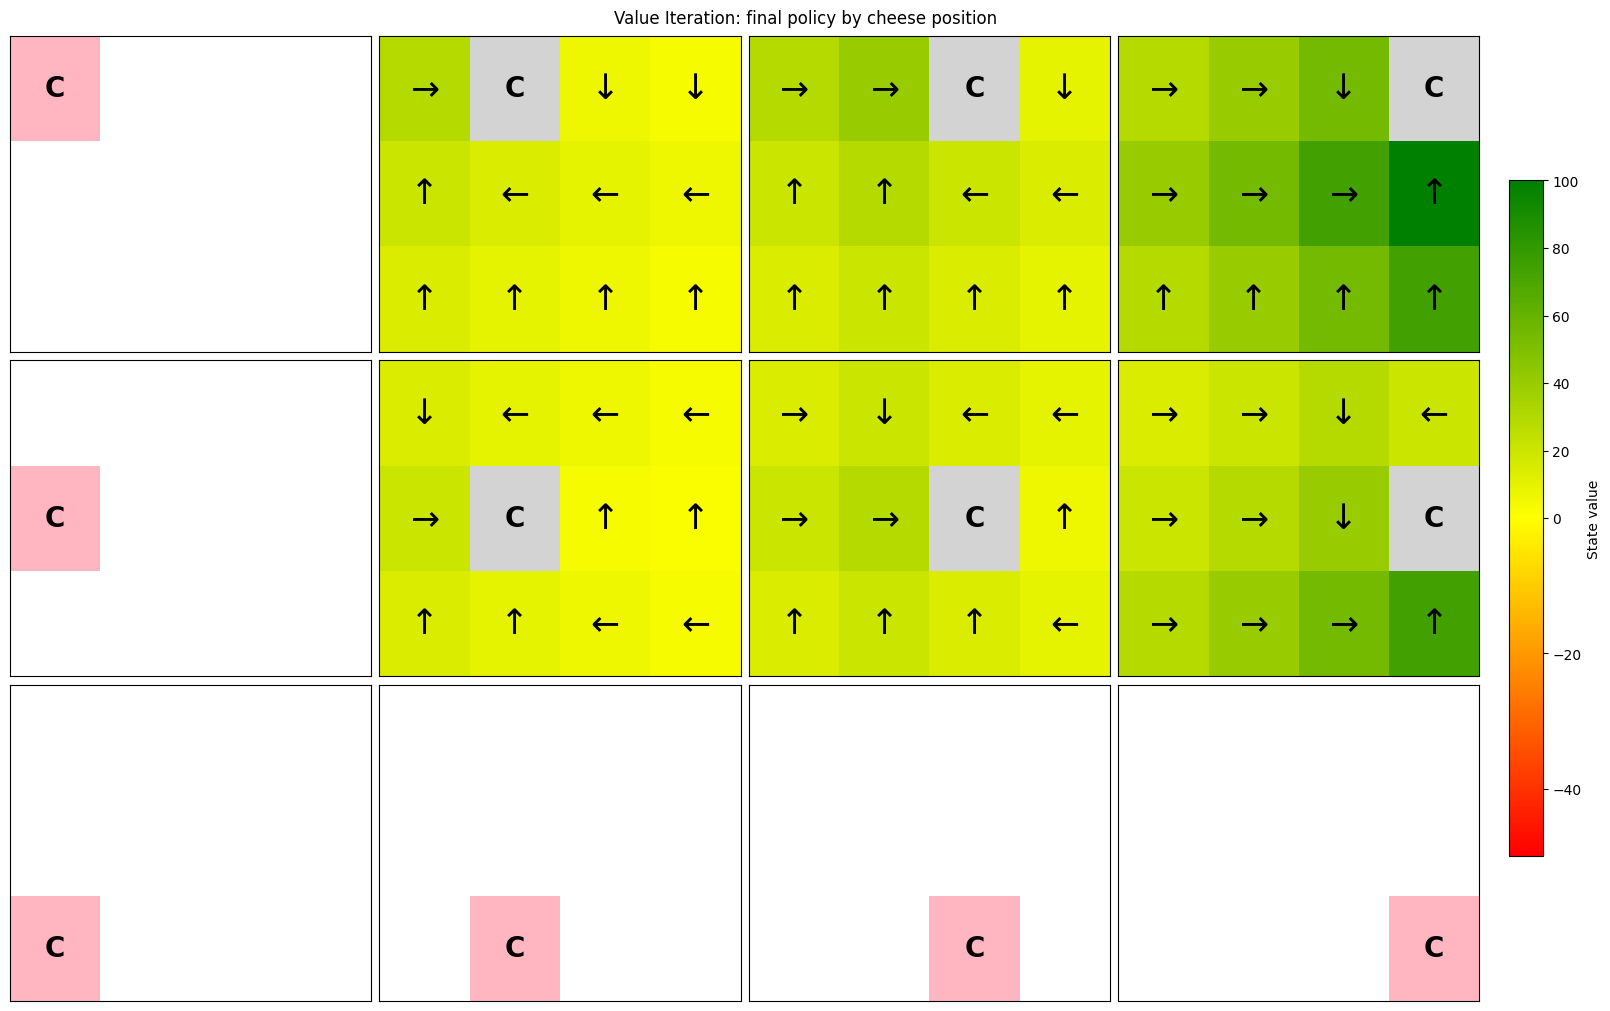

In [7]:
# Define algorithm parameters
theta = 1e-5
discount_rate = 0.75

# Call Value Iteration algorithm
value_itr_policy, value_itr_values, delta_history, value_history = value_iteration(theta=theta, gamma=discount_rate, track_history=True) # type: ignore

print(f"Value Iteration iterations: {len(delta_history)}") # type: ignore

# Figure 1 (Value Iteration details): delta convergence + value history + value distribution
plot_algorithm_details(delta_history, value_history, value_itr_values, "Value Iteration") # type: ignore
plt.show()

# Figure 2 (Value Iteration policy)
plot_policy(value_itr_policy, values=value_itr_values, title="Value Iteration: final policy by cheese position") # type: ignore
plt.show()

### Iteration algorithm comparison

In [8]:
# Comparison plot functions

def plot_policy_agreement(policy_a: dict, policy_b: dict, label_a: str = "Policy A", label_b: str = "Policy B", ax=None):
    non_terminal_states = [s for s in range(MouseEnv.num_of_states) if not MouseEnv.is_terminal_obs(s)]
    agreement = sum(policy_a[s] == policy_b[s] for s in non_terminal_states)
    disagreement = len(non_terminal_states) - agreement

    fig, ax, created_fig = _get_ax(ax, figsize=(6, 4))
    ax.bar(["Agreement", "Disagreement"], [agreement, disagreement])
    _style_axis(ax, f"Policy similarity: {label_a} vs {label_b}", "", "Number of non-terminal states", grid_axis="y")

    if created_fig:
        return fig, ax
    return ax.figure, ax

def plot_value_function_comparison(values_a: dict, values_b: dict, label_a: str = "Values A", label_b: str = "Values B", ax=None):
    x = np.array([values_a[s] for s in sorted(values_a.keys())])
    y = np.array([values_b[s] for s in sorted(values_b.keys())])
    min_v = min(x.min(), y.min())
    max_v = max(x.max(), y.max())

    fig, ax, created_fig = _get_ax(ax, figsize=(6, 6))
    ax.scatter(x, y, alpha=0.6, s=16)
    ax.plot([min_v, max_v], [min_v, max_v], "r--", linewidth=1)
    _style_axis(ax, "State-value comparison", label_a, label_b)

    if created_fig:
        return fig, ax
    return ax.figure, ax

def plot_dp_comparisons(final_policy: dict, value_policy: dict, policy_iteration_values: dict, value_iteration_values: dict):
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    plot_policy_agreement(final_policy, value_policy, label_a="Policy Iteration", label_b="Value Iteration", ax=axes[0])
    plot_value_function_comparison(policy_iteration_values, value_iteration_values, label_a="Policy Iteration state values", label_b="Value Iteration state values", ax=axes[1])
    plt.tight_layout()
    return fig, axes

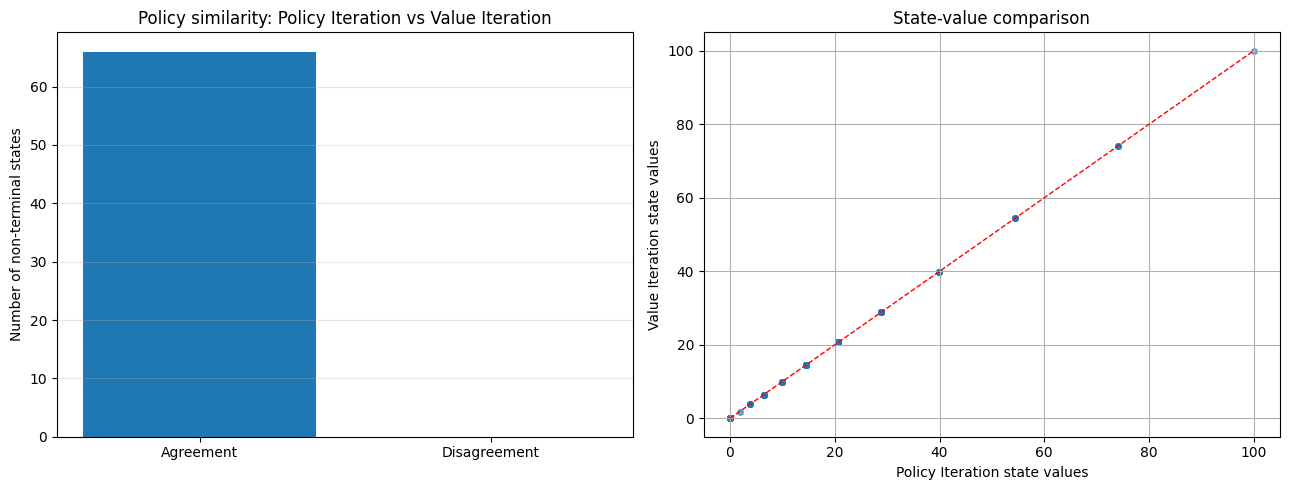

In [9]:
# Policy Iteration vs Value Iteration comparisons
plot_dp_comparisons(policy_itr_values, value_itr_values, policy_itr_values, value_itr_values) # type: ignore
plt.show()

_In this cell, describe how the algorithms work, how the algorithms differ, plot results and/or policies (add more code cells!), etc._

### Discount Rate Analysis

How does the discount rate (γ) affect the state values?

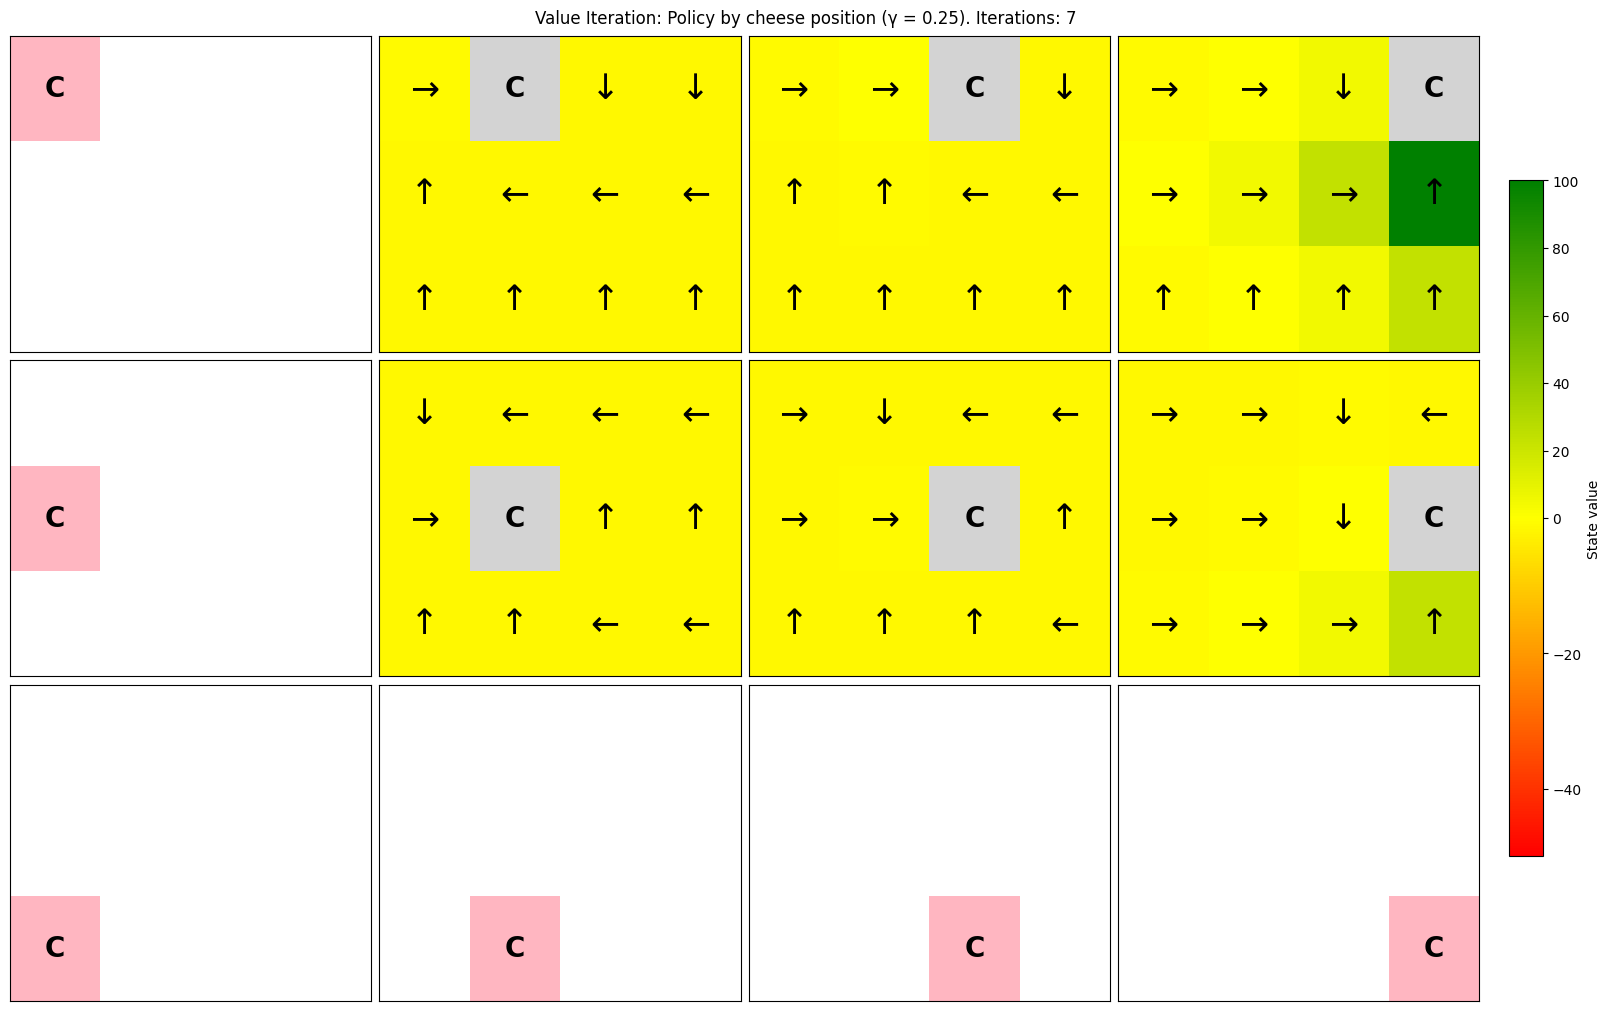

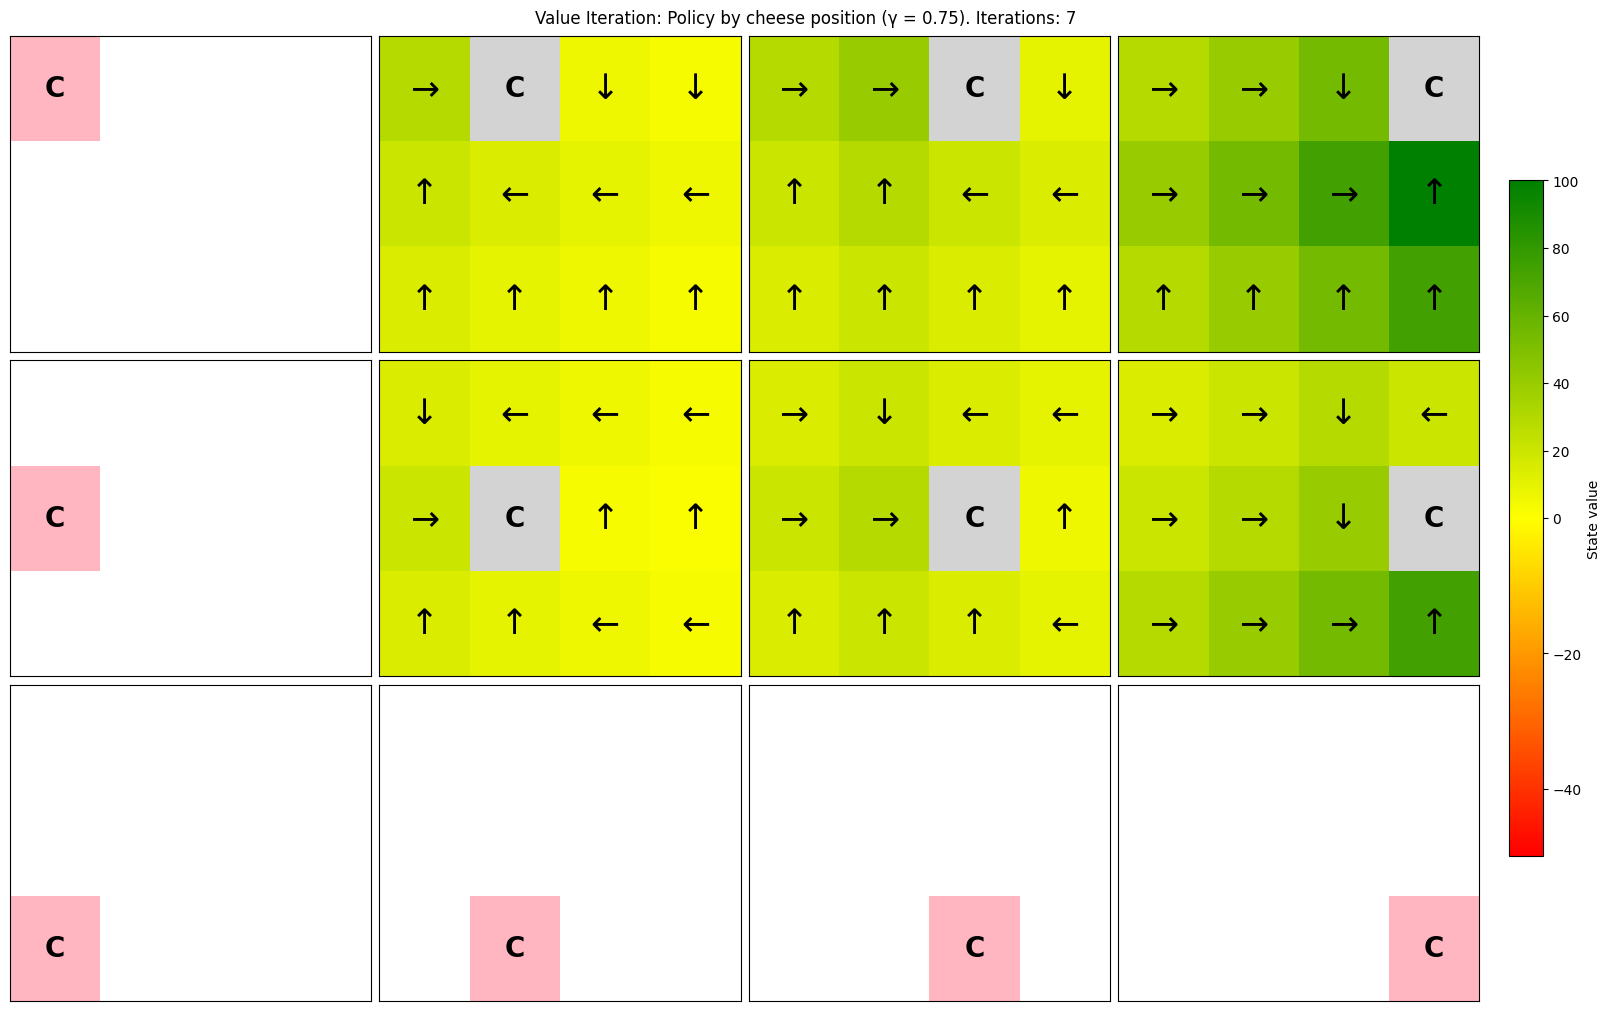

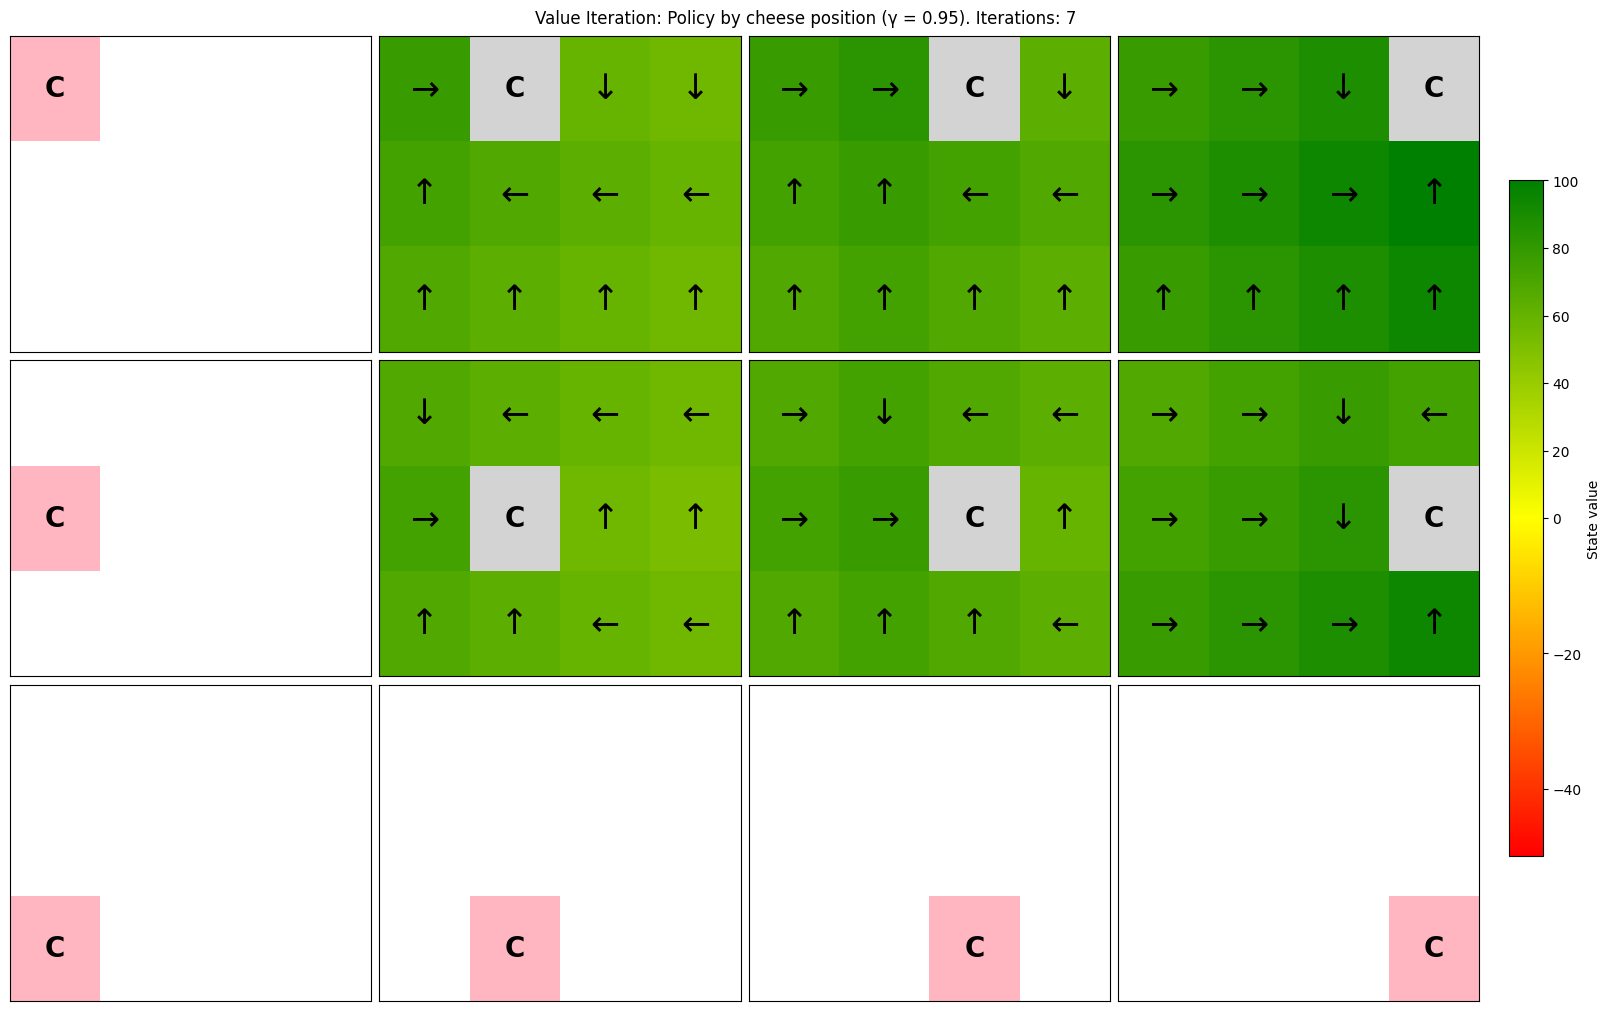

In [10]:
# Analyze effect of discount rate on value functions (Value Iteration)
discount_rates = [0.25, 0.75, 0.95]

for discount in discount_rates:
    # Value Iteration
    policy, values, delta_history, value_history = value_iteration( # type: ignore
        theta=theta,
        gamma=discount,
        track_history=True
    )
    
    # Plot policy with colored squares
    plot_policy(policy, values=values, title=f"Value Iteration: Policy by cheese position (γ = {discount}). Iterations: {len(delta_history)}") # type: ignore
    plt.show()

# 3. Monte Carlo algorithms

First run the Monte Carlo algorithm (Monte Carlo Exploring Starts or Monte Carlo without Exploring Starts (with $\epsilon$-greedy strategy)) by calling functions from the separate `mc.py` file, and create plots. Then, fill in the cell completing your 'report' within this file.

In [11]:
# Call Monte Carlo algorithm
env = MouseEnv()
policy = {state: random.randint(0, env.num_of_actions-1) for state in range(env.num_of_states)}
num_of_episodes = 100
discount = 0.5

print(montecarlo_prediction(policy, env, num_of_episodes, discount))

{0: 0.0, 1: 0.0, 2: -4.0, 3: 0.0, 4: -4.0, 5: 0.0, 6: -3.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: -3.0, 16: -4.0, 17: -4.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: -4.0, 27: -4.0, 28: -3.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: -4.0, 35: -4.0, 36: 0.0, 37: 0.0, 38: -4.0, 39: -4.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: -2.0, 46: -2.0, 47: -2.0, 48: 0.0, 49: -2.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: -2.0, 57: -2.0, 58: -2.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: -3.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: -50.0, 72: -4.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: -4.0, 79: -3.0, 80: 0.0, 81: 0.0, 82: -26.0, 83: -4.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: -4.0, 90: 0.0, 91: -2.0, 92: 0.0, 93: -2.0, 94: -2.0, 95: -4.0, 96: 0.0, 97: 0.0, 98: 0.0, 99: 0.0, 100: 0.0, 101: 0.0, 102: 0.0, 103: 0.0, 104: -2.0, 105: -2.0, 106: -2.0, 10

_In this cell, describe how the algorithms work, how the algorithms differ (compared to the one you did not code), plot results and/or policies (add more code cells!), etc._

# 4. Temporal Difference algorithms

First run the Temporal Difference algorithms (SARSA and Q-learning) by calling functions from the separate `td.py` file, and create plots. Then, fill in the cell completing your 'report' within this file.

In [12]:
# Call SARSA algorithm

In [13]:
# Call Q-learning algorithm

# 5. Comparison and discussion

Compare different algorithms (MC and TD with plots). You don’t need to plot DP alongside MC and TD since DP is not a learning algorithm. However, DP can provide the ground truth for optimal state or action values, which can serve as a reference when evaluating MC and TD. You can choose to plot any of the following: cumulative reward, root mean squared error, sample efficiency, or any other metric you think is a fair comparison.

Include a discussion: what can you conclude by comparing different RL algorithms? Do they have certain strengths or limitations?

_Add as many text cells as you like_

In [14]:
# Add as many code cells as you like

# 6. Conclusion

Conclude your project.

_Add as many text cells as you like_